In [9]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import sys
base = '/home3/ebrahim/isr/'
sys.path.append(base)
from datasets import OneHotLetters
from torch.utils.data import Dataset, DataLoader
from model import RNN_feedback
torch.set_num_threads(2)
import seaborn as sns

In [10]:
def load_accuracy_loss_lists(path, title):
    
    accuracy_list = np.load(path + 'accuracy_list.npy')
    plt.plot(accuracy_list)
    plt.xlabel("Number of trials (tens of thousands)")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()
    loss_list = np.load(path + 'loss_list.npy')
    plt.plot(loss_list)
    plt.xlabel("Number of trials (thousands)")
    plt.ylabel("Loss")
    plt.title(title)

    return accuracy_list



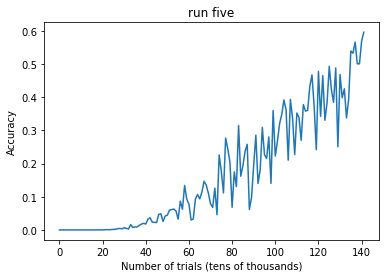

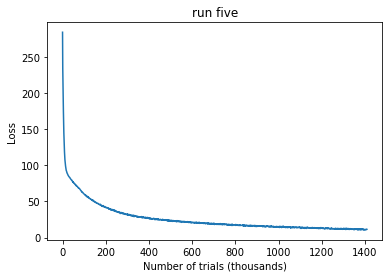

In [11]:
path = base + 'saved_models/simulation_one/run_1/'
acc_list = load_accuracy_loss_lists(path, title='run five')

In [12]:
cranell_6_acc = .53
cranell_model = np.argmin(np.abs(acc_list - .53))

In [99]:
def figures(y_test, y_hat, fig_number):

    predictions = y_hat[:, :, :-1].argmax(2) # batch_size x recall timesteps (ignoring end of list input)
    targets = y_test.argmax(2) # batch_size x recall timesteps
    acc_per_timestep = np.zeros(targets.shape[1])
    transpositions = np.empty((targets.shape[1], targets.shape[0]))
    ppr = torch.all(torch.eq(predictions, targets), dim=1).sum() / y_test.shape[0]
    intrusion_error = 0 

    for timestep in range(y_test.shape[1]):
        for trial in range(y_test.shape[0]):

            # locate position where predicted letter equals targets
            # if correct, matches + 1 should equal timesteps
            matches = np.argwhere((predictions[trial, timestep] == targets[trial]).cpu().numpy())

            # if predicted item is found in target list 
            if matches.shape[0] != 0:
                transpositions[timestep, trial] = int(matches) + 1
            # if predicted item is not in target list, this is an intrusion error 
            else:
                intrusion_error += 1

                
    return ppr, transpositions, omission_error, transposition_errors.item()

In [100]:
def sim_one_figures(model, test_dataloader, test_list_length):

            model.to(device)
            model.eval()
            model.float()

            y_hat_all = []

            for X_test, y_test in test_dataloader:

                X_test = X_test.to(device)
                y_test = y_test.to(device)
                hidden = torch.full((X_test.size(0), hidden_size), .5).to(device)
                y_hat = torch.zeros(X_test.size(0), output_size).to(device)

                with torch.no_grad():
                    # iterate to 2nd to last input (b/c ignoring end of list cue)
                    for timestep in range(X_test.shape[1]-1):
                        y_hat, hidden = model(X_test[:, timestep, :], hidden, y_hat)
                        if timestep >= test_list_length:
                             y_hat_all.append(y_hat)

            ppr, transpositions, oe, te = figures(y_test[:, test_list_length:-1, :], torch.stack(y_hat_all, axis=1), 7)
            print("Transposition error rate: ", te)
            print("Omission error rate: ", oe)
            return ppr, transpositions  


In [16]:
model = torch.load(path + 'final_model.pth')
device = torch.device("cuda:0")
test_size = 5000
hidden_size = 200
input_size = output_size = 27
test_list_length = 6
test_size = 5000
test_dataloader = DataLoader(OneHotLetters(test_list_length, None, test_mode=True), 
                                            batch_size=test_size, shuffle=False)

In [33]:
model = RNN_feedback(10,20,10)
print(model.i2h.parameters)
print(model.h2h.parameters)
print(model.h2o.parameters)
print(model.o2h.parameters)




<bound method Module.parameters of Linear(in_features=10, out_features=20, bias=False)>
<bound method Module.parameters of Linear(in_features=20, out_features=20, bias=True)>
<bound method Module.parameters of Linear(in_features=20, out_features=10, bias=True)>
<bound method Module.parameters of Linear(in_features=10, out_features=20, bias=False)>


Text(-15, -0.1, 'Position')

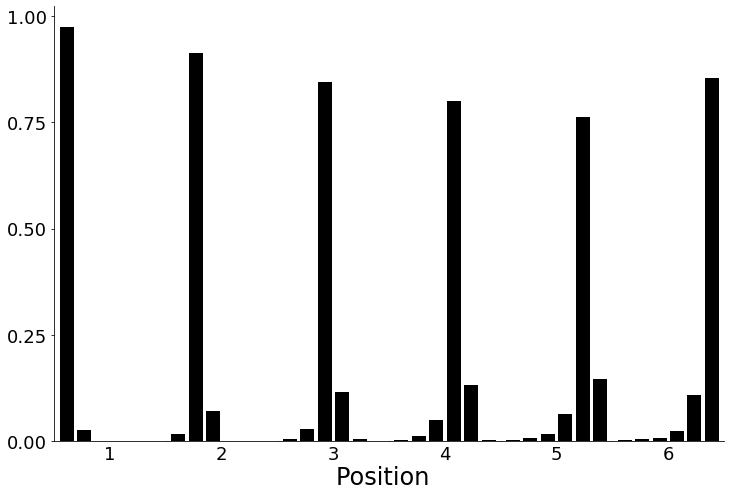

In [72]:
fig, ax = plt.subplots(1,6, sharex=False, sharey=True, figsize=(12,8))
sns.despine()
for i in range(6): 
    ax[i].hist(x = transpositions[i, :], bins=[1,2,3,4,5,6,7], density=True, color=(0,0,0), rwidth=.8)
    ax[i].set_xlabel(i+1, fontsize=18)
    ax[i].set_xticks([])
    ax[i].set_yticks([0, .25, .5, .75, 1])
    ax[0].tick_params(axis='y', which='major', labelsize=18)
    #ax[0].set_yticklabels([0,.5,1], fontsize=14)
    if i > 0:
        ax[i].get_yaxis().set_visible(False)
        sns.despine(left=True, ax=ax[i])
plt.subplots_adjust(wspace=0, hspace=0)
plt.text(-15, -.1, 'Position', fontsize=24)
#plt.hist(bins=np.arange(1,7,1), x=transpositions[0, :])

#plt.hist(bins=np.arange(1,7,1), x=transpositions[1, :])


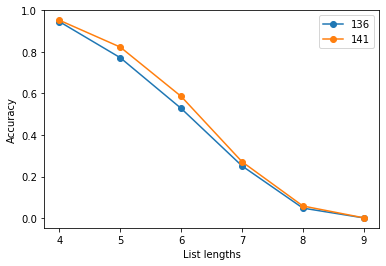

In [37]:
def figure_six_plot():
    
    accuracy_storage = np.zeros((len(num_batches), list_lengths.shape[0]))
    for i, nb in enumerate(num_batches):
        model = torch.load(path + str(nb) + '_model.pth')
        for j, test_list_length in enumerate(list_lengths):
            test_dataloader = DataLoader(OneHotLetters(test_list_length, None, test_mode=True), 
                                            batch_size=test_size, shuffle=False)
            accuracy_storage[i, j] = sim_one_figures(model, test_dataloader, test_list_length)
        plt.plot(list_lengths, accuracy_storage[i, :], marker='o', label=nb)
    plt.xlabel("List lengths")
    plt.ylabel("Accuracy")
    plt.legend()

    return accuracy_storage
        
ac = figure_six()

In [34]:
for i in range(5):
    print(i)

0
1
2
3
4
